## Best BCI example - further spin up

### Libraries 

In [1]:
from scipy.stats import qmc
import numpy as np
import xarray as xr
import csv
import pandas as pd
import os
import netCDF4 as nc4
import sys
from tempfile import TemporaryFile                                                                                                                                 
import argparse                                                                                                                                                     
import shutil                                                                                                                                                       
import tempfile 
import random

#import functions_py.modp as mp
#import fates_xarray_functions as fa

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize

dark = cm.get_cmap('Paired', 12)
colormap = dark(range(12))
colormap[10] = colormap[11]

/global/homes/j/jneedham/.conda/envs/myenv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Load benchmarking data

In [2]:
# regrowth curves 
dfre = pd.read_csv('/global/homes/j/jneedham/DBEN/benchmarking_data/benchmark_regrowth_curves.csv')
dfre = dfre[dfre.Biome == 'Tropics']
print(dfre.head(20))

# stand structure data 
dfss = pd.read_csv('/global/homes/j/jneedham/DBEN/benchmarking_data/benchmark_stand_structure.csv')
dfss = dfss[dfss.site == 'BCI']
#print(dfss.head(5))

# equilibrium dynamics
dfeq = pd.read_csv('/global/homes/j/jneedham/DBEN/benchmarking_data/benchmark_eq_dynamics.csv')
dfeq = dfeq[dfeq.site == 'BCI']
#print(dfeq.head(5))


  bin_ranges  bin_num  AGcwood_kgCm2_med  AGcwood_kgCm2_10  AGcwood_kgCm2_90  \
0     [0,20]       10           2.686585          0.437423          8.854919   
1    (20,40]       30           6.498622          2.712175         14.247400   
2    (40,60]       50           7.919361          3.084988         20.623452   
3    (60,80]       70           8.371820          3.925260         19.883572   

     Biome final  
0  Tropics     Y  
1  Tropics     Y  
2  Tropics     Y  
3  Tropics     Y  


### Load FATES

In [3]:
fates = '/pscratch/sd/j/jneedham/elm_runs/dben/sims2024/bci_spinup_highco2.Ef14a3cf738-F2c2f3f10.2024-06-21/run/bci_spinup_highco2.Ef14a3cf738-F2c2f3f10.2024-06-21.sofar.nc'
fates = xr.open_dataset(fates,  decode_times=False)

nyears = int(len(fates.variables['time'])/12)
n_lat = len(fates.variables['lat'])
n_lon = len(fates.variables['lon'])

tave_start = (nyears-5)
tave_stop = nyears

cohort_size_bins = fates.variables['fates_levscls']
patch_age_bins = fates.variables['fates_levage'][:]
nsizebins = len(cohort_size_bins)

time = fates.variables['time'] / 365.

print(len(time))

agb_frac = 0.6

7680


In [4]:
# this function takes data that has monthly values and returns a single annual value, with 
# a mean that accounts for the number of days per month
def monthly_to_annual(array):
    """ calculate annual mean from monthly data, using unequal month lengths for noleap calendar.  
    originally written by Keith Lindsay."""
    mon_day  = xr.DataArray(np.array([31.,28.,31.,30.,31.,30.,31.,31.,30.,31.,30.,31.]), dims=['month'])
    mon_wgt  = mon_day/mon_day.sum()
    return (array.rolling(time=12, center=False) # rolling
            .construct("month") # construct the array
            .isel(time=slice(11, None, 12)) # slice so that the first element is [1..12], second is [13..24]
            .dot(mon_wgt, dims=["month"]))

### Coexistence

Text(0, 0.5, 'Veg C (kg C m-2)')

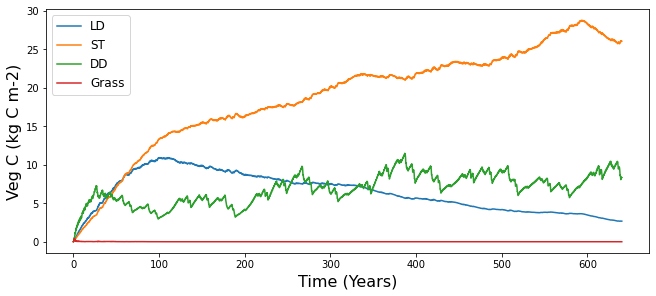

In [5]:
AGB = fates.FATES_VEGC_PF

fig1, axs = plt.subplots(nrows=1,ncols=1, figsize=(9,4), constrained_layout=True)
axs.plot(time, AGB[:,0],label = 'LD')  
axs.plot(time, AGB[:,1], label = 'ST')   
axs.plot(time, AGB[:,2],  label = 'DD')   
axs.plot(time, AGB[:,3],  label = 'Grass')  
axs.legend(prop={'size':12})

axs.set_xlabel(r'Time (Years)', fontsize=16)
axs.set_ylabel(r'Veg C (kg C m-2)', fontsize=16)

        

### Equilibrium AGB

''

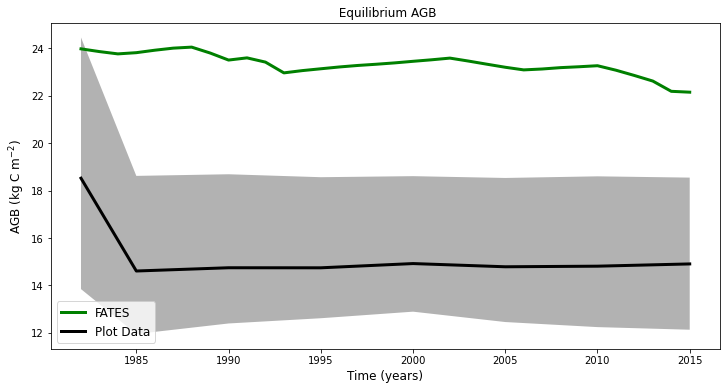

In [6]:
time_plot = list(dfeq.Year)
agb_plot = dfeq.AGB_kgCm2
agb_plot_lower = dfeq.AGB_lower_kgCm2
agb_plot_upper = dfeq.AGB_upper_kgCm2

eq_time = np.arange(time_plot[0], (time_plot[-1]+1), 1)
tstart = nyears-(len(eq_time))
tstop = nyears


AGB = monthly_to_annual(fates.FATES_VEGC_ABOVEGROUND)

fig1, ((f1ax0)) = plt.subplots(nrows=1,ncols=1, figsize=(12,6))
f1ax0.plot(eq_time, AGB[tstart:tstop], color='green', label = 'FATES', linewidth=3)    
f1ax0.set_title(r' Equilibrium AGB', fontsize = 12)
f1ax0.set_ylabel(r'AGB (kg C m$^{-2}$)', fontsize = 12)
f1ax0.set_xlabel(r'Time (years)', fontsize = 12)    
   
f1ax0.plot(time_plot, agb_plot, color='black', label = 'Plot Data', linewidth=3)
f1ax0.fill_between(time_plot, agb_plot_lower, agb_plot_upper, alpha=0.6, facecolor='grey')

f1ax0.legend(prop={'size':12})
;

### Size distributions

In [7]:
# dbh_classes_num are UPPER  bounds. Remove the  first size  bin
plot_sizebin = np.array(dfss.dbh_classes_num)
plot_sizebin_mids = (plot_sizebin[0:-1] + plot_sizebin[1:])/2
plot_sizebin_widths = plot_sizebin[1:] - plot_sizebin[:-1]
plot_nplant = dfss['nstem_size_ha.1']

# size bins are LOWER bounds. Remove the fist bin - but add an extra bin to catch trees over last bin edge
cohort_size_bins_ex = np.append(cohort_size_bins[1:], 250)
fates_sizebin_mids = (cohort_size_bins_ex[0:-1] + cohort_size_bins_ex[1:])/2
fates_sizebin_widths = cohort_size_bins_ex[1:] - cohort_size_bins_ex[:-1]

''

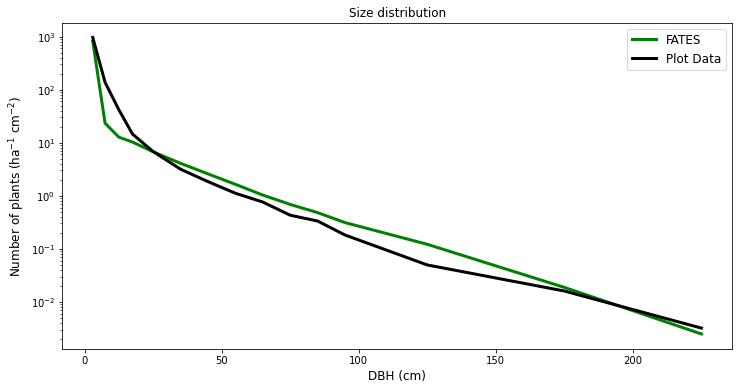

In [8]:
nplant = monthly_to_annual(fates.FATES_NPLANT_SZ)
nplant = np.squeeze(nplant.isel(time=slice(300,tave_stop)).mean(dim='time')) * 10000 # convert to plants per ha (from m-2)

plot_sd = plot_nplant.iloc[1:]/plot_sizebin_widths
fates_sd = nplant[1:]/fates_sizebin_widths


fig2, ((f2ax0)) = plt.subplots(nrows=1,ncols=1, figsize=(12,6))
f2ax0.plot(fates_sizebin_mids, fates_sd, color='green', label = 'FATES', linewidth=3)    
   
f2ax0.set_title(r'Size distribution', fontsize = 12)
f2ax0.set_ylabel(r'Number of plants (ha$^{-1}$ cm$^{-2}$)', fontsize = 12)
f2ax0.set_xlabel(r'DBH (cm)', fontsize = 12)    
       
f2ax0.plot(plot_sizebin_mids, plot_sd, color='black', label = 'Plot Data', linewidth = 3)
f2ax0.set_yscale('log')
f2ax0.legend(prop={'size':12})
;

### Carbon by size 

''

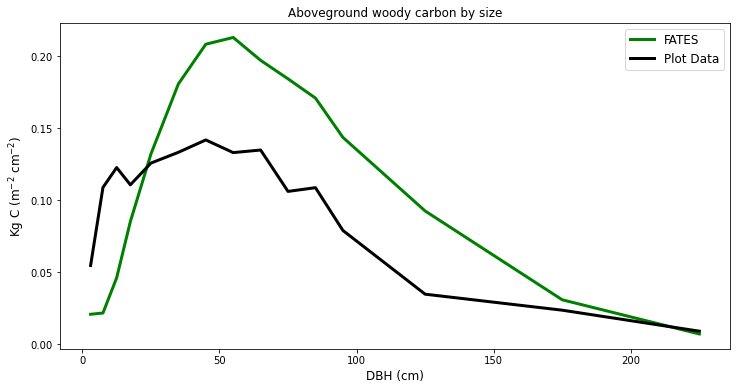

In [9]:
agb_frac = 0.6
WOODC = monthly_to_annual(fates.FATES_WOODC_SZ)
WOODC = np.squeeze(WOODC.isel(time=slice(300,tave_stop)).mean(dim='time')) * agb_frac
fates_agb_sd = WOODC[1:]/fates_sizebin_widths

fig3, ((f3ax0)) = plt.subplots(nrows=1,ncols=1, figsize=(12,6))

f3ax0.plot(fates_sizebin_mids, fates_agb_sd, color='green', label = 'FATES', linewidth=3)    
f3ax0.set_title(r'Aboveground woody carbon by size', fontsize = 12)
f3ax0.set_ylabel(r'Kg C (m$^{-2}$ cm$^{-2}$)', fontsize = 12)
f3ax0.set_xlabel(r'DBH (cm)', fontsize = 12)    
       
plot_cwood_sz = dfss['AGB_size_kgCm.2']
plot_agb_sd = plot_cwood_sz[1:]/plot_sizebin_widths 
f3ax0.plot(plot_sizebin_mids, plot_agb_sd, color='black', label = 'Plot Data', linewidth=3)
f3ax0.legend(prop={'size':12})
;

''

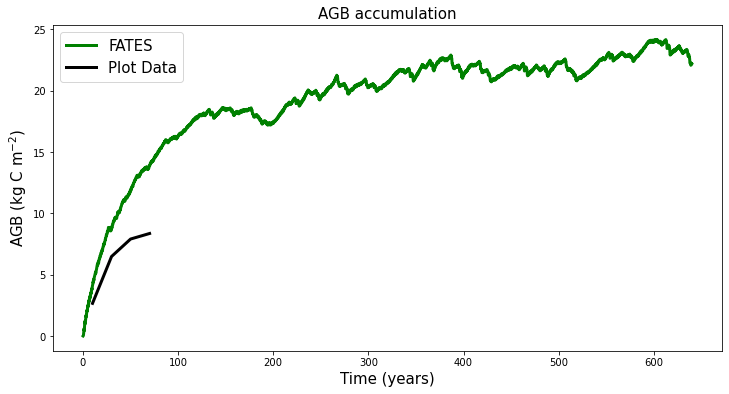

In [10]:
AGB = fates.FATES_VEGC_ABOVEGROUND


fig1, ((f1ax0)) = plt.subplots(nrows=1,ncols=1, figsize=(12,6))
f1ax0.plot(time, AGB, color='green', label = 'FATES', linewidth=3)    

f1ax0.set_title(r'AGB accumulation', fontsize = 15)
f1ax0.set_ylabel(r'AGB (kg C m$^{-2}$)', fontsize = 15)
f1ax0.set_xlabel(r'Time (years)', fontsize = 15)    
   
time_plot = dfre.bin_num
agb_plot = dfre.AGcwood_kgCm2_med

f1ax0.plot(time_plot, agb_plot, color='black', label = 'Plot Data', linewidth =3)

f1ax0.legend(prop={'size':15})
;